# Autonomous RAG with LangGraph v1.x

Implementation of an autonomous RAG system that combines:
- Query Planning & Decomposition
- Chain-of-Thought reasoning
- ReAct-style agent loop (Reason → Act → Observe)
- Iterative retrieval with self-reflection
- Answer synthesis from multiple sources

This implementation uses LangGraph v1.x patterns with TypedDict state management,
Command-based routing, and structured outputs via Pydantic.

In [1]:
# Install required packages
# pip install langchain langgraph langchain-groq langchain-huggingface langchain-chroma langchain-community chromadb wikipedia pydantic

In [2]:
import os
from dotenv import load_dotenv

load_dotenv()
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

## Load and Prepare Vector Store

We use Wikipedia as our knowledge source and ChromaDB for vector storage.
Documents are chunked with overlap to preserve context at boundaries.

In [3]:
from langchain_community.document_loaders import WikipediaLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_chroma import Chroma

# Load documents from Wikipedia on transformer architectures
loader = WikipediaLoader(query="Transformer (deep learning)", load_max_docs=5)
documents = loader.load()
print(f"Loaded {len(documents)} Wikipedia pages")

# Split documents into chunks for better retrieval precision
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200
)
docs = text_splitter.split_documents(documents)
print(f"Split into {len(docs)} chunks")

/Users/yashsarode/Downloads/Personal Projects/Python/LangChain-LangGraph/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded 5 Wikipedia pages
Split into 27 chunks


In [4]:
# Initialize embeddings model - runs locally for privacy and speed
embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-mpnet-base-v2",
    model_kwargs={"device": "cpu"},
    encode_kwargs={"normalize_embeddings": True}
)

# Create vector store with local persistence
vector_store = Chroma(
    collection_name="autonomous_rag",
    embedding_function=embeddings,
    persist_directory="./chroma_autonomous_rag"
)

# Add documents to vector store
vector_store.add_documents(docs)
print(f"Vector store created with {len(docs)} documents")

Vector store created with 27 documents


## Initialize LLM

Using Groq Cloud with llama-3.3-70b-versatile for fast inference.
This model supports both structured outputs and tool calling.

In [5]:
from langchain_groq import ChatGroq

llm = ChatGroq(
    model="llama-3.3-70b-versatile",
    temperature=0
)

## Define State Schema

State stores raw data that nodes read from and write to.
Each node can access all state fields but only updates specific fields.
This design follows LangGraph best practices: store raw data, format on-demand in nodes.

In [6]:
from typing import TypedDict, List
from langchain_core.documents import Document

class AutonomousRAGState(TypedDict):
    """State for autonomous RAG workflow.
    
    Stores raw data that gets passed between nodes.
    Nodes format this data as needed in their prompts.
    """
    question: str                      # Original user query
    sub_questions: List[str]           # Decomposed sub-queries from planner
    reasoning_steps: List[str]         # Chain-of-thought reasoning steps
    retrieved_docs: List[Document]     # Documents from retrieval
    answer: str                        # Generated answer
    reflection: str                    # Self-reflection on answer quality
    verified: bool                     # Whether answer passes quality check
    refined_question: str              # Query refinement for re-retrieval
    attempts: int                      # Number of retrieval-generation cycles

## Define Pydantic Schemas for Structured Outputs

LangGraph v1.x uses Pydantic for structured LLM outputs.
These schemas ensure the LLM returns data in expected formats.

In [7]:
from pydantic import BaseModel, Field
from typing import Literal

class SubQuestions(BaseModel):
    """Schema for query decomposition."""
    sub_questions: List[str] = Field(
        description="List of 2-3 focused sub-questions that break down the main query"
    )

class ReasoningSteps(BaseModel):
    """Schema for chain-of-thought reasoning."""
    steps: List[str] = Field(
        description="Sequential reasoning steps to approach the question"
    )

class AnswerReflection(BaseModel):
    """Schema for self-reflection on answer quality."""
    is_complete: Literal["yes", "no"] = Field(
        description="Whether the answer fully addresses the question"
    )
    reasoning: str = Field(
        description="Explanation of why the answer is or isn't complete"
    )
    suggested_refinement: str = Field(
        description="If incomplete, how to refine the query for better results"
    )

## Create Structured LLMs

We augment the base LLM with schemas for different tasks.
This ensures type-safe outputs that match our expected data structures.

In [8]:
# LLM for query planning
query_planner_llm = llm.with_structured_output(SubQuestions)

# LLM for chain-of-thought reasoning
cot_llm = llm.with_structured_output(ReasoningSteps)

# LLM for reflection
reflection_llm = llm.with_structured_output(AnswerReflection)

## Define Workflow Nodes

Each node is a function that:
1. Takes current state as input
2. Performs one specific task
3. Returns updates to state

Nodes use Command objects to specify both state updates and routing decisions.

In [9]:
from langgraph.types import Command
from typing import Literal

def query_planner(state: AutonomousRAGState) -> Command[Literal["cot_reasoner"]]:
    """Decompose complex query into focused sub-questions.
    
    Query planning helps handle multifaceted questions by breaking them
    into smaller, more retrievable sub-queries.
    """
    prompt = f"""Break down this question into 2-3 focused sub-questions that can be 
answered independently. Each sub-question should target a specific aspect.

Question: {state['question']}"""
    
    result = query_planner_llm.invoke(prompt)
    
    return Command(
        update={"sub_questions": result.sub_questions},
        goto="cot_reasoner"
    )

In [10]:
def cot_reasoner(state: AutonomousRAGState) -> Command[Literal["retrieve_docs"]]:
    """Generate reasoning steps using chain-of-thought.
    
    CoT helps the model break down complex reasoning into explicit steps,
    improving answer quality and making the process more interpretable.
    """
    # Format sub-questions into context
    sub_q_text = "\n".join([f"- {q}" for q in state["sub_questions"]])
    
    prompt = f"""Given this main question and its sub-questions, outline the reasoning 
steps needed to answer it comprehensively.

Main Question: {state['question']}

Sub-questions:
{sub_q_text}

Provide 3-4 logical reasoning steps."""
    
    result = cot_llm.invoke(prompt)
    
    return Command(
        update={
            "reasoning_steps": result.steps,
            "attempts": state.get("attempts", 0) + 1
        },
        goto="retrieve_docs"
    )

In [11]:
def retrieve_docs(state: AutonomousRAGState) -> Command[Literal["generate_answer"]]:
    """Retrieve relevant documents for all sub-questions.
    
    Retrieves docs for each sub-question and combines them.
    Uses refined query on subsequent attempts for better results.
    """
    all_docs = []
    
    # On first attempt, use sub-questions; on retry, use refined query
    queries = [state.get("refined_question", state["question"])] if state.get("refined_question") else state["sub_questions"]
    
    for query in queries:
        docs = vector_store.similarity_search(query, k=2)
        all_docs.extend(docs)
    
    # Remove duplicates based on content
    seen_content = set()
    unique_docs = []
    for doc in all_docs:
        if doc.page_content not in seen_content:
            seen_content.add(doc.page_content)
            unique_docs.append(doc)
    
    return Command(
        update={"retrieved_docs": unique_docs},
        goto="generate_answer"
    )

In [12]:
def generate_answer(state: AutonomousRAGState) -> Command[Literal["reflect_on_answer"]]:
    """Generate answer using retrieved context and reasoning steps.
    
    Combines all gathered context into a comprehensive prompt.
    Formats state data on-demand rather than storing formatted text.
    """
    # Format context from raw state data
    context_text = "\n\n".join([
        f"Document {i+1}:\n{doc.page_content}"
        for i, doc in enumerate(state["retrieved_docs"])
    ])
    
    reasoning_text = "\n".join([
        f"{i+1}. {step}"
        for i, step in enumerate(state["reasoning_steps"])
    ])
    
    prompt = f"""Answer the following question using the provided context and reasoning steps.
Be comprehensive but concise. Use the reasoning steps to structure your answer.

Question: {state['question']}

Reasoning Steps:
{reasoning_text}

Retrieved Context:
{context_text}

Answer:"""
    
    response = llm.invoke(prompt)
    
    return Command(
        update={"answer": response.content},
        goto="reflect_on_answer"
    )

In [13]:
def reflect_on_answer(state: AutonomousRAGState) -> Command[Literal["refine_query", "__end__"]]:
    """Evaluate answer quality and decide if refinement is needed.
    
    Self-reflection allows the system to catch incomplete answers
    and trigger iterative retrieval for better results.
    """
    prompt = f"""Evaluate whether this answer fully addresses the question.
Consider if it covers all aspects and provides sufficient detail.

Question: {state['question']}

Answer: {state['answer']}

Provide your assessment."""
    
    reflection = reflection_llm.invoke(prompt)
    
    verified = reflection.is_complete == "yes"
    
    # Stop if verified or max attempts reached
    if verified or state["attempts"] >= 3:
        return Command(
            update={
                "reflection": reflection.reasoning,
                "verified": verified
            },
            goto="__end__"
        )
    
    # Otherwise, refine and retry
    return Command(
        update={
            "reflection": reflection.reasoning,
            "verified": False,
            "refined_question": reflection.suggested_refinement
        },
        goto="refine_query"
    )

In [14]:
def refine_query(state: AutonomousRAGState) -> Command[Literal["retrieve_docs"]]:
    """Refine the query based on reflection feedback.
    
    This node prepares for re-retrieval with an improved query.
    The refined query was already generated in reflect_on_answer.
    """
    print(f"Refining query (attempt {state['attempts']}): {state['refined_question']}")
    
    return Command(
        update={},
        goto="retrieve_docs"
    )

## Build the Graph

We wire nodes together using a StateGraph.
The graph follows a flexible flow:
- Query Planning → CoT Reasoning → Retrieval → Answer Generation → Reflection
- Reflection can loop back via Refinement for iterative improvement

In [15]:
from langgraph.graph import StateGraph, START, END

# Initialize graph builder
workflow = StateGraph(AutonomousRAGState)

# Add all nodes to the graph
workflow.add_node("query_planner", query_planner)
workflow.add_node("cot_reasoner", cot_reasoner)
workflow.add_node("retrieve_docs", retrieve_docs)
workflow.add_node("generate_answer", generate_answer)
workflow.add_node("reflect_on_answer", reflect_on_answer)
workflow.add_node("refine_query", refine_query)

# Define the workflow edges
workflow.add_edge(START, "query_planner")

# Nodes use Command to handle their own routing
# We only need essential edges here

# Compile the graph
autonomous_rag = workflow.compile()

print("Graph compiled successfully")

Graph compiled successfully


## Visualize the Graph

LangGraph provides built-in visualization to understand workflow structure.

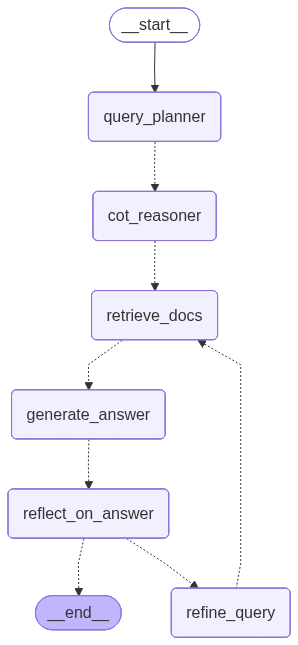

In [16]:
from IPython.display import Image, display

try:
    display(Image(autonomous_rag.get_graph().draw_mermaid_png()))
except Exception:
    print("Graph visualization requires graphviz. Install with: pip install pygraphviz")
    print("Or use: brew install graphviz (macOS) / apt-get install graphviz (Linux)")

## Test the Autonomous RAG System

Let's test with a complex question that requires:
- Decomposition into sub-questions
- Multi-document retrieval
- Reasoning to synthesize information

In [17]:
# Test query
test_question = """How does the transformer architecture differ from RNNs, 
and what specific advantages does the attention mechanism provide for parallel processing?"""

# Initialize state
initial_state = {
    "question": test_question,
    "sub_questions": [],
    "reasoning_steps": [],
    "retrieved_docs": [],
    "answer": "",
    "reflection": "",
    "verified": False,
    "refined_question": "",
    "attempts": 0
}

# Run the autonomous RAG workflow
print("Running Autonomous RAG...\n")
final_state = autonomous_rag.invoke(initial_state)

# Display results
print("="*80)
print("AUTONOMOUS RAG RESULTS")
print("="*80)
print(f"\nOriginal Question:\n{final_state['question']}")
print(f"\n{'='*80}")
print(f"\nSub-Questions Generated:")
for i, sq in enumerate(final_state['sub_questions'], 1):
    print(f"{i}. {sq}")
print(f"\n{'='*80}")
print(f"\nReasoning Steps:")
for i, step in enumerate(final_state['reasoning_steps'], 1):
    print(f"{i}. {step}")
print(f"\n{'='*80}")
print(f"\nDocuments Retrieved: {len(final_state['retrieved_docs'])}")
print(f"\n{'='*80}")
print(f"\nFinal Answer:\n{final_state['answer']}")
print(f"\n{'='*80}")
print(f"\nReflection: {final_state['reflection']}")
print(f"Verified: {final_state['verified']}")
print(f"Attempts: {final_state['attempts']}")
print(f"\n{'='*80}")

Running Autonomous RAG...

AUTONOMOUS RAG RESULTS

Original Question:
How does the transformer architecture differ from RNNs, 
and what specific advantages does the attention mechanism provide for parallel processing?


Sub-Questions Generated:
1. What are the key differences between the transformer architecture and RNNs?
2. How does the attention mechanism in transformers enable parallel processing?
3. What specific advantages does the attention mechanism provide over traditional RNN-based approaches?


Reasoning Steps:
1. Identify the key differences between the transformer architecture and RNNs, focusing on how they process sequential data
2. Explain how the attention mechanism in transformers enables parallel processing by allowing the model to weigh the importance of different input elements simultaneously
3. Discuss the specific advantages of the attention mechanism over traditional RNN-based approaches, including its ability to handle long-range dependencies and reduce sequentia

## Stream Execution for Real-time Updates

LangGraph supports streaming to show progress as the workflow executes.

In [18]:
# Stream example - shows step-by-step execution
print("Streaming execution...\n")

for event in autonomous_rag.stream(initial_state, stream_mode="updates"):
    for node_name, node_output in event.items():
        print(f"\n[{node_name}]")
        if "sub_questions" in node_output and node_output["sub_questions"]:
            print(f"Generated {len(node_output['sub_questions'])} sub-questions")
        if "reasoning_steps" in node_output and node_output["reasoning_steps"]:
            print(f"Generated {len(node_output['reasoning_steps'])} reasoning steps")
        if "retrieved_docs" in node_output:
            print(f"Retrieved {len(node_output['retrieved_docs'])} documents")
        if "answer" in node_output and node_output["answer"]:
            print(f"Generated answer ({len(node_output['answer'])} chars)")
        if "verified" in node_output:
            print(f"Answer verified: {node_output['verified']}")

Streaming execution...


[query_planner]
Generated 3 sub-questions

[cot_reasoner]
Generated 4 reasoning steps

[retrieve_docs]
Retrieved 5 documents

[generate_answer]
Generated answer (1908 chars)

[reflect_on_answer]
Answer verified: True


## Key Takeaways

This autonomous RAG implementation demonstrates several LangGraph v1.x patterns:

1. **State Management**: TypedDict stores raw data; nodes format it on-demand
2. **Structured Outputs**: Pydantic schemas ensure type-safe LLM responses
3. **Command-based Routing**: Nodes specify both updates and next destinations
4. **Iterative Refinement**: Self-reflection enables quality-driven loops
5. **Query Decomposition**: Complex questions are broken into focused sub-queries
6. **Chain-of-Thought**: Explicit reasoning steps improve answer quality
7. **Multi-source Synthesis**: Documents from multiple retrievals are combined

The system autonomously decides when answers are sufficient and when
to perform additional retrieval cycles, making it more robust than
simple RAG implementations.